There may be errors in parsing wiki pages from snapshot and this notebook help quantify the errors
by comparing the parsed versions from snapshots with the latest html version retrieved from the
wikipedia api.

Sources of errors:
1. Snapshot is old and out of sync with the latest wikipedia page
2. Templates are not expanded in the snapshot

... and may be more unknown reasons

This notebook uses the wikipedia api to retrieve the latest html version of the page and compares
quantities of interest like internal links, category labels, etc. between the snapshot and the latest
version on a sample of pages to estimate the error rate.

# Conclusion after running the notebook:

There are two major sources of errors:
1. Internal links inside infoboxes of articles are not extracted mwparserfromhell. As a result, only 30% of the internal links are extracted per page on average.
2. Templates are not expanded in the snapshot. As a result, ~30% of category to parent category links are missing in the snapshot.

Everything else that we care about seems to be extracted correctly.

In [137]:
import requests
import importlib
import json, time, random, numpy as np
import src.wiki_parser as wiki_parser
from collections import Counter
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import clear_output
import re

_ = importlib.reload(wiki_parser)

In [136]:
"""
Methodology:
1. Get a sample of 10000 pages from processed summaries
2. Shuffle them randomly
3. Process them one-by-one to compute defect rate for a prefix of length i
    - call wikipedia api on need basis (and cache results)
    - fetch full text in batches of 1000
4. Progressively compute following quantities on the prefix of length i:
    - fraction of redirect pages that are not present in the wikipedia api exactly
    - fraction of category pages containing a template somewhere in parent category set in the local data
    - Fraction of category pages for which parent category set doesn't match the parent category set from the wikipedia api
        - break down by whether template is present in it or not
    - Fraction of category to parent links in wikipedia api that are missing in the local data 
    - Fraction of category to parent links in local data that are missing in the wikipedia api
    - Fraction of normal pages for which the internal links don't match the internal links from the wikipedia api exactly
    - Fraction of normal pages for which the category set doesn't match the category set from the wikipedia api exactly
    - Fraction of page-category links in wikipedia api that are missing in the local data
    - Fraction of page-category links in local data that are missing in the wikipedia api
    - Fraction of internal links in wikipedia api that are missing in the local data
    - Fraction of internal links in local data that are missing in the wikipedia api
5. Plot the above quantities as a function of i and break the loop when it looks like the defect rate has stabilized
"""
_ = 1

In [7]:
data_root_dir = r'C:\Users\mohitvyas\MyDesktop\WikipediaDataset\data\\'

In [8]:
# sample N random pages for defect rate measurement from processed summaries
N = 50000
selection_probability = N / 2e7
sampled_pages = []
silent = False
processed_line_count = 0
start_time = time.time()

random_numbers, curr_idx = np.random.rand(100000), 0

for i in range(10):
    with open(data_root_dir + f'processed_summaries/part-{i}.txt', 'r') as f:
        for line in f:
            if curr_idx == 100000:
                random_numbers, curr_idx = np.random.rand(100000), 0
            if random_numbers[curr_idx] < selection_probability:
                sampled_pages.append(json.loads(line))
            processed_line_count += 1
            curr_idx += 1
            if processed_line_count % 1000000 == 0 and not silent:
                print(f"Processed {processed_line_count} lines in {(time.time() - start_time) / 60} minutes")

    print(f"Finished part {i} in {(time.time() - start_time) / 60} minutes")

print(f"Final sample count: {len(sampled_pages)}")

Processed 1000000 lines in 0.06218676567077637 minutes
Processed 2000000 lines in 0.11141978899637858 minutes
Finished part 0 in 0.11982853412628174 minutes
Processed 3000000 lines in 0.15137992699941 minutes
Processed 4000000 lines in 0.1929918130238851 minutes
Finished part 1 in 0.20068643093109131 minutes
Processed 5000000 lines in 0.22655535538991292 minutes
Processed 6000000 lines in 0.2644801338513692 minutes
Finished part 2 in 0.27654298146565753 minutes
Processed 7000000 lines in 0.3213885426521301 minutes
Processed 8000000 lines in 0.3771264910697937 minutes
Finished part 3 in 0.3910643498102824 minutes
Processed 9000000 lines in 0.42092545827229816 minutes
Processed 10000000 lines in 0.46259549458821614 minutes
Finished part 4 in 0.4775929848353068 minutes
Processed 11000000 lines in 0.5065008163452148 minutes
Processed 12000000 lines in 0.5506867090861003 minutes
Finished part 5 in 0.5678758144378662 minutes
Processed 13000000 lines in 0.5978854974110921 minutes
Processed 14

In [9]:
# load index. Needed to full contents of the pages
snapshot_name = 'enwiki-20240501-pages-articles-multistream'

start_time = time.time()
parser = wiki_parser.WikiParser(data_root_dir+snapshot_name+"-index.txt.bz2", 
                                data_root_dir+snapshot_name+".xml.bz2")
print (f"Time taken to load the index: {time.time() - start_time} seconds")

Time taken to load the index: 97.35484337806702 seconds


In [21]:
page_type_counts = Counter()
for page in sampled_pages:
    if page['namespace']==14:
        page_type_counts['category'] += 1
    elif page['redirect_title'] is not None:
        page_type_counts['redirect'] += 1
    else:
        page_type_counts['normal'] += 1

print (f"Page type counts: {page_type_counts}")

page_type_percentages = {k: round(100 * v/len(sampled_pages), 2) for k, v in page_type_counts.items()}
print (f"Page type percentages: {page_type_percentages}")

# show project page type counts as a sanity check 
projected_page_type_counts = {k: "{:,}".format(int(v / selection_probability)) for k, v in page_type_counts.items()}
print (f"Projected page type counts: {projected_page_type_counts}")


Page type counts: Counter({'redirect': 27303, 'normal': 16819, 'category': 5917})
Page type percentages: {'normal': 33.61, 'redirect': 54.56, 'category': 11.82}
Projected page type counts: {'normal': '6,727,600', 'redirect': '10,921,200', 'category': '2,366,800'}


In [22]:
shuffled_sampled_pages = random.sample(sampled_pages, len(sampled_pages))

In [25]:
# WARNING: running this cell clears cache
# cache data for wikipedia api calls and expensive local snapshot page fetches
cached_data = {
    'wiki_api': {},
    'snapshot_pages': {}
}

In [29]:
# https://en.wikipedia.org/w/api.php?action=parse&page=Pet_door&prop=text|categories|links&formatversion=2

def fetch_expanded_wikipedia_page(page_title):
    URL = "https://en.wikipedia.org/w/api.php"
    PARAMS = {
        "action": "parse",
        "page": page_title,
        "prop": "text|categories|links",
        "format": "json",
        "formatversion": "2"
    }

    response = requests.get(URL, params=PARAMS)

    return response.json()

In [206]:
def compute_redirect_page_metrics(page_summary, wiki_api_data):
    # returns true or false based on whether the page summary details
    assert page_summary['redirect_title'] is not None, "Page is not a redirect page"
    metrics = {
        'page_id': page_summary['page_id'],
        'redirect_page_exact_match': {'sum': 1, 'count': 1}
    }
    if page_summary['page_id']!=wiki_api_data.get('parse', {}).get('pageid', None):
        metrics['redirect_page_exact_match']['sum'] = 0
    elif page_summary['title']!=wiki_api_data['parse']['title']:
        metrics['redirect_page_exact_match']['sum'] = 0
    else:
        links = list(filter(lambda l: l['ns']==0, wiki_api_data['parse']['links']))
        if len(links)!=1 or links[0]['title']!=page_summary['redirect_title']:
            metrics['redirect_page_exact_match']['sum'] = 0
    return metrics

In [207]:
def compute_normal_page_metrics(page_summary, wiki_api_data):
    assert page_summary['redirect_title'] is None, "Page is a redirect page"
    metrics = {
        'page_id': page_summary['page_id'],
        'normal_page_exists_in_wiki_api': {'sum': 1, 'count': 1},
        'page_internal_link_set_exact_match': {'sum': 1, 'count': 1},
        'page_category_set_exact_match': {'sum': 1, 'count': 1},
        'page_category_links_covered_in_local': {'sum': 0, 'count': 0},
        'page_category_links_covered_in_wiki_api': {'sum': 0, 'count': 0},
        'page_internal_links_covered_in_local': {'sum': 0, 'count': 0},
        'page_internal_links_covered_in_wiki_api': {'sum': 0, 'count': 0}
    }
    local_link_set = set(page_summary['internal_links'])
    local_category_set = set([c.lower().replace(' ', '_') for c in page_summary['categories']])
    wiki_api_link_set = set()
    for link in wiki_api_data['parse']['links']:
        if link['ns']==0 and link.get('exists', False):
            wiki_api_link_set.add(link['title'])
    wiki_api_category_set = set()
    for category in wiki_api_data['parse']['categories']:
        if not category.get('hidden', False):
            wiki_api_category_set.add(category['category'].lower().replace(' ', '_'))
    metrics['normal_page_exists_in_wiki_api']['sum'] = int(page_summary['page_id']==wiki_api_data.get('parse', {}).get('pageid', None))
    metrics['page_internal_link_set_exact_match']['sum'] = int(local_link_set==wiki_api_link_set)
    metrics['page_category_set_exact_match']['sum'] = int(local_category_set==wiki_api_category_set)
    metrics['page_category_links_covered_in_local']['sum'] = len(wiki_api_category_set) - len(wiki_api_category_set - local_category_set)
    metrics['page_category_links_covered_in_local']['count'] = len(wiki_api_category_set)
    metrics['page_category_links_covered_in_wiki_api']['sum'] = len(local_category_set) - len(local_category_set - wiki_api_category_set)
    metrics['page_category_links_covered_in_wiki_api']['count'] = len(local_category_set)
    metrics['page_internal_links_covered_in_local']['sum'] = len(wiki_api_link_set) - len(wiki_api_link_set - local_link_set)
    metrics['page_internal_links_covered_in_local']['count'] = len(wiki_api_link_set)
    metrics['page_internal_links_covered_in_wiki_api']['sum'] = len(local_link_set) - len(local_link_set - wiki_api_link_set)
    metrics['page_internal_links_covered_in_wiki_api']['count'] = len(local_link_set)
    return metrics

In [208]:
def compute_category_page_metrics(page_summary, wiki_api_data):
    assert page_summary['namespace']==14, "Page is not a category page"
    metrics = {
        'page_id': page_summary['page_id'],
        'category_page_exists_in_wiki_api': {'sum': 1, 'count': 1},
        'category_has_templates_in_parents': {'sum': 0, 'count': 1},
        'category_parent_set_exact_match': {'sum': 1, 'count': 1},
        'category_parent_links_covered_in_local': {'sum': 0, 'count': 0},
        'category_parent_links_covered_in_wiki_api': {'sum': 0, 'count': 0}
    }
    local_parent_set = set([c.lower().replace(' ', '_') for c in page_summary['categories']])
    metrics['category_page_exists_in_wiki_api']['sum'] = int(wiki_api_data.get('parse', {}).get('pageid', None) == page_summary['page_id'])
    wiki_api_parent_set = set()
    for category in wiki_api_data.get('parse', {}).get('categories', []):
        if not category.get('hidden', False):
            wiki_api_parent_set.add(category['category'].lower().replace(' ', '_'))
    metrics['category_parent_set_exact_match']['sum'] = int(local_parent_set==wiki_api_parent_set)
    metrics['category_parent_links_covered_in_local']['sum'] = len(wiki_api_parent_set) - len(wiki_api_parent_set - local_parent_set)
    metrics['category_parent_links_covered_in_local']['count'] = len(wiki_api_parent_set)
    metrics['category_parent_links_covered_in_wiki_api']['sum'] = len(local_parent_set) - len(local_parent_set - wiki_api_parent_set)
    metrics['category_parent_links_covered_in_wiki_api']['count'] = len(local_parent_set)
    for category in local_parent_set:
        if re.search(r'{{.*}}', category):
            metrics['category_has_templates_in_parents']['sum'] = 1
            break
    return metrics

In [209]:
def plot_metrics(metrics, page_type_counts, start_time, sample_size_granularity=10):
    clear_output(wait=True)

    print (f"Processed {sum(page_type_counts.values())} pages in {(time.time() - start_time) / 60} minutes")
    # show bar plot of page type counts
    pd.DataFrame(page_type_counts.items())\
        .plot(kind='bar', x=0, y=1, legend=False, rot=45, title='Page Type Counts')
    plt.xlabel('Page Type')
    plt.ylabel('Count')
    plt.grid()
    plt.gcf().set_size_inches(3, 2)
    plt.show()

    # show average of each metric over different sample sizes
    # plot is a line graph where x-axis is sample size (in multiples of 100)
    # and y-axis is the average of the metric over the sample. Hue is the metric name
    metrics_pdf = []
    metric_summary = {}
    for sample_id in range(len(metrics)):
        for metric_name, metric_value in metrics[sample_id].items():
            if metric_name!='page_id':
                if metric_name not in metric_summary:
                    metric_summary[metric_name] = {'sum': 0, 'count': 0}
                metric_summary[metric_name]['sum'] += metric_value['sum']
                metric_summary[metric_name]['count'] += metric_value['count']
        if (sample_id+1) % sample_size_granularity == 0:
            for metric_name in metric_summary:
                metrics_pdf.append({
                    'sample_size': (sample_id+1),
                    'metric_name': metric_name,
                    'metric_value': 100 * metric_summary[metric_name]['sum'] / metric_summary[metric_name]['count']
                })
    metrics_pdf = pd.DataFrame(metrics_pdf)
    final_metric_averages = metrics_pdf.groupby(['metric_name'])[['sample_size']].max().reset_index()
    final_metric_averages = final_metric_averages.merge(metrics_pdf, on=['metric_name', 'sample_size'], how='inner')
    final_metric_averages = final_metric_averages.groupby(['metric_name'])[['metric_value']].max().reset_index()
    # create a 2x2 grid of plots based on final metric value
    # metrics with [100 to 75] goes in top left, [75 to 50] in top right, [50 to 25] in bottom left, [25 to 0] in bottom right
    segment_to_metric = {}
    for i in range(4):
        segment_to_metric[i] = final_metric_averages[
            (final_metric_averages['metric_value']<=100-25*i) & (final_metric_averages['metric_value']>100-25*(i+1))
        ]['metric_name'].values
    fig, axs = plt.subplots(2, 2)
    fig.set_size_inches(20, 6)
    for i in range(4):
        ax = axs[i//2, i%2]
        sns.lineplot(data=metrics_pdf[metrics_pdf['metric_name'].isin(segment_to_metric[i])], x='sample_size', y='metric_value', hue='metric_name', ax=ax)
        ax.set_title(f"Metrics in range {100-25*(i+1)} to {100-25*i}")
        ax.set_xlabel('Sample size')
        ax.set_ylabel('Percentage')
        ax.grid()
        # move legend outside the plot
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.tight_layout()
    plt.show()

Processed 2002 pages in 0.05687319040298462 minutes


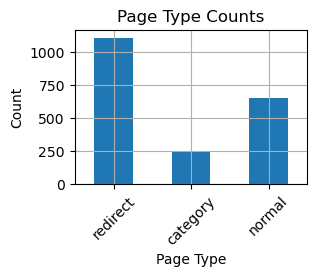

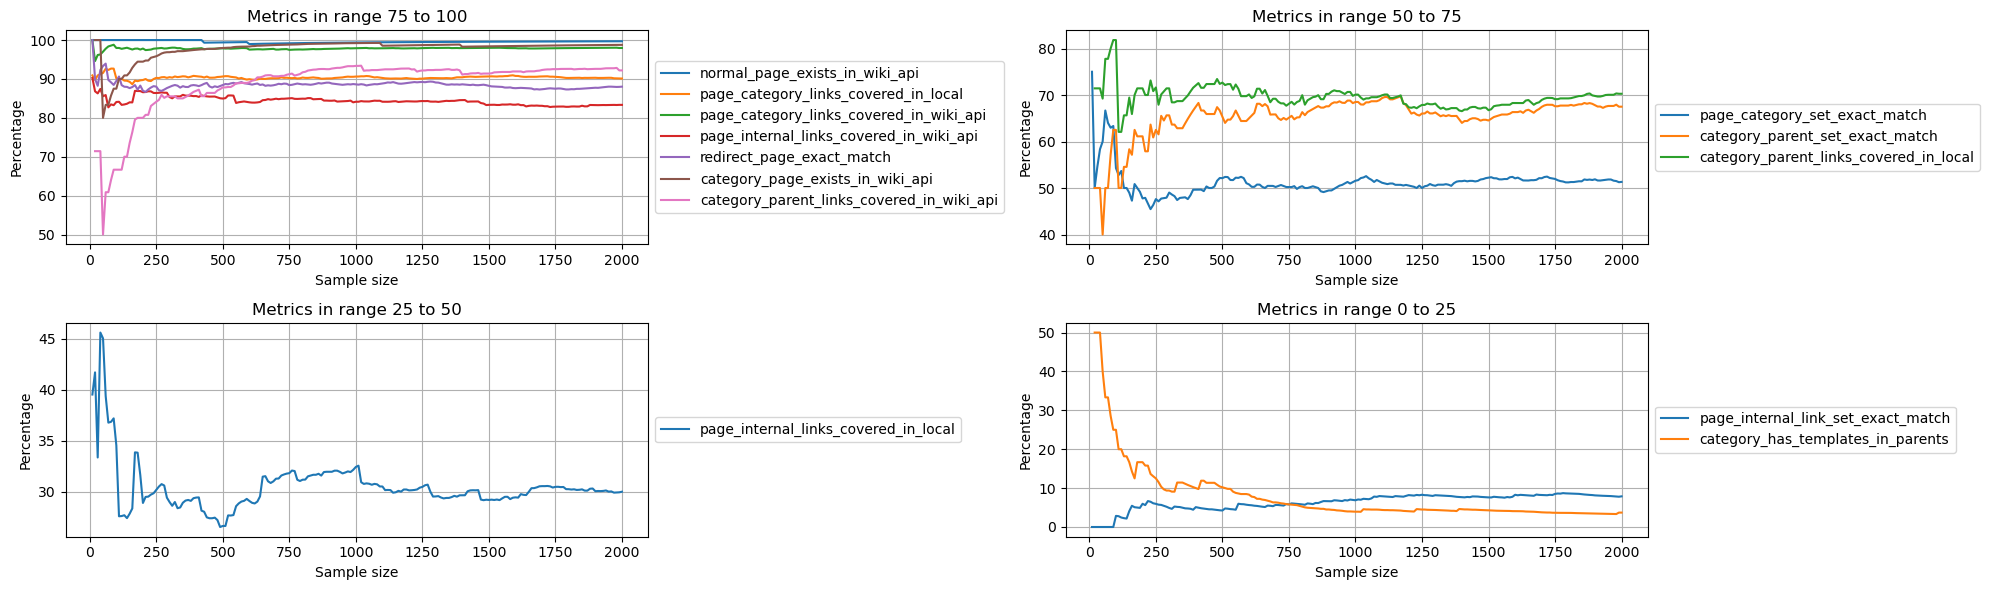

In [219]:
last_refresh_time = time.time()
start_time = time.time()
last_refresh_index = -1
page_type_counts = {
    'redirect': 0,
    'category': 0,
    'normal': 0
}
metrics = []
for i in range(len(shuffled_sampled_pages)):
    page = shuffled_sampled_pages[i]
    if page['page_id'] not in cached_data['snapshot_pages']:
        # fetch next 100 pages from snapshot
        page_ids = [p['page_id'] for p in shuffled_sampled_pages[i:i+100]]
        for page in parser.page_stream(page_ids, include_text=True):
            cached_data['snapshot_pages'][page['page_id']] = page
    if page['page_id'] not in cached_data['wiki_api']:
        # fetch from wikipedia api
        title = page['title'].replace(' ', '_')
        if page['namespace'] == 14:
            title = 'Category:' + title
        wiki_api_data = fetch_expanded_wikipedia_page(title)
        cached_data['wiki_api'][page['page_id']] = wiki_api_data
    if page['namespace'] == 0 and page['redirect_title'] is not None:
        metrics.append(compute_redirect_page_metrics(page, cached_data['wiki_api'][page['page_id']]))
        page_type_counts['redirect'] += 1
    elif page['namespace'] == 0:
        metrics.append(compute_normal_page_metrics(page, cached_data['wiki_api'][page['page_id']]))
        page_type_counts['normal'] += 1
    elif page['namespace'] == 14:
        metrics.append(compute_category_page_metrics(page, cached_data['wiki_api'][page['page_id']]))
        page_type_counts['category'] += 1
    else:
        raise ValueError(f"Unknown namespace: {page['namespace']}")
    if time.time() - last_refresh_time > 10:
        plot_metrics(metrics, page_type_counts, start_time)
        last_refresh_time = time.time()
        last_refresh_index = i
        # save cache
        with open('tmp/defect_rate_cache_1.json', 'w') as f:
            json.dump(cached_data, f)
        with open('tmp/defect_rate_metrics_2.json', 'w') as f:
            json.dump(cached_data, f)
    if i>2000:
        break
plot_metrics(metrics, page_type_counts, start_time)

In [213]:
page
shuffled_sampled_pages[i]

{'categories': ['Actors from Suzhou',
  'Male actors from Jiangsu',
  'Male actors by city or town in China'],
 'internal_links': [],
 'text_length': 1,
 'num_unique_words': 1,
 'number_of_files': 0,
 'number_of_external_links': 0,
 'number_of_info_boxes': 0,
 'number_of_sections': 1,
 'page_id': 41562533,
 'title': 'Male actors from Suzhou',
 'redirect_title': None,
 'namespace': 14}

In [202]:
idx = 45

# check pages where lots of internal links aren't covered
# found page https://en.wikipedia.org/wiki/International_House,_The_University_of_Sydney -> this one had tons of links inside an infobox which weren't captured in the local snapshot
# same issue with 
# - https://en.wikipedia.org/wiki/Cinereous_owl 
# - https://en.wikipedia.org/wiki/Chubby_Grigg
# - https://en.wikipedia.org/wiki/Aristolochia_sempervirens

c=0
for idx in range(len(metrics)):
    if 'page_internal_links_covered_in_local' in metrics[idx]:
        d = metrics[idx]['page_internal_links_covered_in_local']
        if d['sum'] < 0.5 * d['count']:
            c+=1
            if c>3:
                break

# check pages where category to parent links are not covered in local. Especially ones where template is not present
# Issue-1: parents are encoded using templates that aren't expanded. Examples
# - https://en.wikipedia.org/wiki/Category:1528_disestablishments
# - https://en.wikipedia.org/wiki/Category:20th-century_establishments_in_Chile
# almost all of them are due to templates not being expanded. Template doesn't necessarily have to be in the parent category set
# it can be in the text of the page itself which then expands into a category link
c=0
for idx in range(len(metrics)):
    if 'category_parent_links_covered_in_local' in metrics[idx]:
        d = metrics[idx]['category_parent_links_covered_in_local']
        if d['sum'] < 0.6 * d['count']:
            c+=1
            if c>6:
                break


print (json.dumps(metrics[idx], indent=2))
page_id = metrics[idx]['page_id']

print (json.dumps(shuffled_sampled_pages[idx], indent=2))
print (json.dumps(cached_data['wiki_api'][page_id], indent=2))
print (json.dumps(cached_data['snapshot_pages'][page_id], indent=2))


{
  "page_id": 32506721,
  "category_page_exists_in_wiki_api": {
    "sum": 1,
    "count": 1
  },
  "category_has_templates_in_parents": {
    "sum": 0,
    "count": 1
  },
  "category_parent_set_exact_match": {
    "sum": 0,
    "count": 1
  },
  "category_parent_links_covered_in_local": {
    "sum": 2,
    "count": 5
  },
  "category_parent_links_covered_in_wiki_api": {
    "sum": 2,
    "count": 2
  }
}
{
  "categories": [
    "20th-century establishments in South America",
    "2nd-millennium establishments in Chile"
  ],
  "internal_links": [],
  "text_length": 4,
  "num_unique_words": 4,
  "number_of_files": 0,
  "number_of_external_links": 0,
  "number_of_info_boxes": 0,
  "number_of_sections": 1,
  "page_id": 32506721,
  "title": "20th-century establishments in Chile",
  "redirect_title": null,
  "namespace": 14
}
{
  "parse": {
    "title": "Category:20th-century establishments in Chile",
    "pageid": 32506721,
    "text": "<div class=\"mw-content-ltr mw-parser-output\" lang

In [133]:
for idx in range(100):
    page = shuffled_sampled_pages[idx]
    wiki_api_data = cached_data['wiki_api'][page['page_id']]
    snapshot_page = cached_data['snapshot_pages'][page['page_id']]
    if page['namespace'] == 14: break

In [134]:

# snapshot_page

{'categories': ['Companies established in {{title year}} by country',
  'Companies of Canada by year of establishment',
  '{{title year}} establishments in Canada'],
 'internal_links': [],
 'text_length': 8,
 'num_unique_words': 7,
 'number_of_files': 0,
 'number_of_external_links': 0,
 'number_of_info_boxes': 0,
 'number_of_sections': 1,
 'page_id': 64260423,
 'title': 'Canadian companies established in 1902',
 'redirect_title': None,
 'namespace': 14}

In [135]:
wiki_api_data

{'parse': {'title': 'Category:Canadian companies established in 1902',
  'pageid': 64260423,
  'text': '<div class="mw-content-ltr mw-parser-output" lang="en" dir="ltr"><style data-mw-deduplicate="TemplateStyles:r1201935656">.mw-parser-output .categorySeriesNavigation{display:flow-root}.mw-parser-output .categorySeriesNavigation-range{display:table;border-collapse:separate;margin:auto;padding:8px;text-align:center}body.skin-vector-2022 .mw-parser-output .categorySeriesNavigation-range,body.skin-minerva .mw-parser-output .categorySeriesNavigation-range{padding:3px}.mw-parser-output .categorySeriesNavigation-range-transparent{border-width:0;background-color:transparent}.mw-parser-output .categorySeriesNavigation-item-inactive{color:#72777d}</style><div class="categorySeriesNavigation" role="navigation" aria-label="Range">\n<div class="toccolours categorySeriesNavigation-range">\n<style data-mw-deduplicate="TemplateStyles:r1129693374">.mw-parser-output .hlist dl,.mw-parser-output .hlist o

In [139]:
compute_category_page_metrics(page, wiki_api_data)

{'page_id': 64260423,
 'category_has_templates_in_parents': {'sum': 1, 'count': 1},
 'category_parent_set_exact_match': {'sum': 0, 'count': 1},
 'category_parent_links_covered_in_local': {'sum': 1, 'count': 3},
 'category_parent_links_covered_in_wiki_api': {'sum': 1, 'count': 3}}

In [36]:
# fetch full raw data for sampled pages
sampled_ids = [page['page_id'] for page in sampled_pages]
page_id_to_full_raw_data = {}

for page in parser.page_stream(sampled_ids, include_text=True):
    page_id_to_full_raw_data[page['page_id']] = page

In [33]:
page_id_to_full_raw_data[sampled_ids[4]]

{'page_id': 16229,
 'title': 'Joystick',
 'redirect_title': None,
 'namespace': 0,
 'text': '{{Short description|Control lever used in aircraft and video games}}\n{{Redirect|Control stick|the joystick often called a control stick in many controllers|Analog stick}}\n{{Other uses}}\n\n[[Image:Joyopis.svg|right|thumb|Possible elements of a video game joystick: 1.&nbsp;stick, 2.&nbsp;base, 3.&nbsp;trigger, 4.&nbsp;extra buttons, 5.&nbsp;autofire switch, 6.&nbsp;throttle, 7.&nbsp;[[#Hat switch|hat switch (POV hat)]], 8.&nbsp;suction cups.]]\n\nA \'\'\'joystick\'\'\', sometimes called a \'\'\'flight stick\'\'\', is an [[input device]] consisting of a stick that pivots on a base and reports its angle or direction to the device it is controlling. A joystick, also known as the \'\'\'control column\'\'\', is the principal control device in the [[cockpit]] of many civilian and military aircraft, either as a [[centre stick]] or [[side-stick]]. It has various switches to control functions of the ai

In [25]:
# count how many sampled pages are redirects, category pages, normal pages
sampled_pages[0]

{'categories': [],
 'internal_links': ['List of sovereign states'],
 'text_length': 5,
 'num_unique_words': 5,
 'number_of_files': 0,
 'number_of_external_links': 0,
 'number_of_info_boxes': 0,
 'number_of_sections': 1,
 'page_id': 5074,
 'title': 'CountriesH',
 'redirect_title': 'List of sovereign states',
 'namespace': 0}

In [ ]:
"""
Quantities to measure:
- fraction of category pages with 
"""

In [9]:




# Example usage
page_title = "Category:1945 in Alabama"
page_title = "Coriander"
html_content = fetch_expanded_wikipedia_page(page_title)

# save page content to a file
with open("tmp/tmp.html", "w") as file:
    file.write(html_content)

TypeError: write() argument must be str, not dict

In [10]:
html_content

{'parse': {'title': 'Coriander',
  'pageid': 341640,
  'text': '<div class="mw-content-ltr mw-parser-output" lang="en" dir="ltr"><div class="shortdescription nomobile noexcerpt noprint searchaux" style="display:none">Annual herb</div>\n<style data-mw-deduplicate="TemplateStyles:r1033289096">.mw-parser-output .hatnote{font-style:italic}.mw-parser-output div.hatnote{padding-left:1.6em;margin-bottom:0.5em}.mw-parser-output .hatnote i{font-style:normal}.mw-parser-output .hatnote+link+.hatnote{margin-top:-0.5em}</style><div role="note" class="hatnote navigation-not-searchable">This article is about the herb. For other uses, see <a href="/wiki/Coriander_(disambiguation)" class="mw-disambig" title="Coriander (disambiguation)">Coriander (disambiguation)</a>.</div>\n<link rel="mw-deduplicated-inline-style" href="mw-data:TemplateStyles:r1033289096"><div role="note" class="hatnote navigation-not-searchable">"Cilantro" redirects here. Not to be confused with the related herb <i><a href="/wiki/Eryn

In [6]:
html_content

{'parse': {'title': 'Category:1945 in Alabama',
  'pageid': 39812076,
  'text': '<div class="mw-content-ltr mw-parser-output" lang="en" dir="ltr"><style data-mw-deduplicate="TemplateStyles:r1217611005">.mw-parser-output .side-box{margin:4px 0;box-sizing:border-box;border:1px solid #aaa;font-size:88%;line-height:1.25em;background-color:#f9f9f9;display:flow-root}.mw-parser-output .side-box-abovebelow,.mw-parser-output .side-box-text{padding:0.25em 0.9em}.mw-parser-output .side-box-image{padding:2px 0 2px 0.9em;text-align:center}.mw-parser-output .side-box-imageright{padding:2px 0.9em 2px 0;text-align:center}@media(min-width:500px){.mw-parser-output .side-box-flex{display:flex;align-items:center}.mw-parser-output .side-box-text{flex:1;min-width:0}}@media(min-width:720px){.mw-parser-output .side-box{width:238px}.mw-parser-output .side-box-right{clear:right;float:right;margin-left:1em}.mw-parser-output .side-box-left{margin-right:1em}}</style><div class="side-box side-box-right plainlinks s

In [4]:
from bs4 import BeautifulSoup
import pyperclip

# extract links
links = []
soup = BeautifulSoup(html_content, "html.parser")
pyperclip.copy(soup.prettify())